In [58]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import os
import errno

import numpy as np

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import Adam

from deepcell import make_training_data
from deepcell.model_zoo import bn_multires_feature_net
from deepcell.model_zoo import disc_net
from deepcell.training import train_model_conv, train_model_disc
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler

In [59]:
# data options
DATA_OUTPUT_MODE = 'conv'
PADDING = 'valid' if DATA_OUTPUT_MODE == 'sample' else 'same'
RESIZE = True
RESHAPE_SIZE = 256

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/unspecified_nuclear_data/nuclei/'
DATA_FILE = 'disc_{}_{}'.format(K.image_data_format(), DATA_OUTPUT_MODE)

for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
    try:
        os.makedirs(os.path.join(d, PREFIX))
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

In [60]:
# Generate training data
file_name_save = os.path.join(NPZ_DIR, PREFIX, DATA_FILE)
num_of_features = 2  # Specify the number of feature masks that are present
window_size = (30, 30)  # Size of window around pixel
training_direcs = ['set1', 'set2', 'set3', 'set4', 'set5', 'set6', 'set7', 'set8', 'set9']
channel_names = ['nuclear']
raw_image_direc = ''
annotation_direc = ''

# Create the training data
make_training_data(
    direc_name=os.path.join(DATA_DIR, PREFIX),
    dimensionality=2,
    max_training_examples=1e6, # Define maximum number of training examples
    window_size_x=window_size[0],
    window_size_y=window_size[1],
    padding=PADDING,
    file_name_save=file_name_save,
    training_direcs=training_direcs,
    channel_names=channel_names,
    num_of_features=num_of_features,
    raw_image_direc=raw_image_direc,
    annotation_direc=annotation_direc,
    reshape_size=RESHAPE_SIZE if RESIZE else None,
    edge_feature=[1, 0, 0], # Specify which feature is the edge feature,
    dilation_radius=1,
    output_mode=DATA_OUTPUT_MODE,
    display=False,
    verbose=True)

Reshaped feature data from (9, 1080, 1280, 3) to (225, 256, 256, 3)
Reshaped training data from (9, 1080, 1280, 1) to (225, 256, 256, 1)
Number of features: 3
Number of training data points: 14745600
Class weights: [9.65855499 3.88487025 0.37892337]


In [61]:
# Foreground/background model
direc_save = os.path.join(MODEL_DIR, PREFIX)
direc_data = os.path.join(NPZ_DIR, PREFIX)
training_data = np.load(os.path.join(direc_data, DATA_FILE + '.npz'))

class_weights = training_data['class_weights']
X, y = training_data['X'], training_data['y']

n_epoch = 20
batch_size = 32 if DATA_OUTPUT_MODE == 'sample' else 1
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
lr_sched = rate_scheduler(lr=0.0001, decay=0.99)

is_channels_first = K.image_data_format() == 'channels_first'
row_axis = 2 if is_channels_first else 1
col_axis = 3 if is_channels_first else 2
channel_axis = 1 if is_channels_first else 3

size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[row_axis:col_axis + 1]
if is_channels_first:
    input_shape = (X.shape[channel_axis], size[0], size[1])
else:
    input_shape = (size[0], size[1], X.shape[channel_axis])

fgbg_model = bn_multires_feature_net(
    input_shape=input_shape,
    n_features=3,
    location=False)

train_model_conv(
    model=fgbg_model,
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    direc_save=direc_save,
    direc_data=direc_data,
    lr_sched=lr_sched,
    expt='fgbg',
    class_weight=class_weights,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (202, 256, 256, 1)
y_train shape: (202, 256, 256, 3)
X_test shape: (23, 256, 256, 1)
y_test shape: (23, 256, 256, 3)
Output Shape: (None, 256, 256, 3)
Number of Classes: 3
Using real-time data augmentation.
Epoch 1/20
201/202 [============================>.] - ETA: 0s - loss: 0.6135 - acc: 0.5621
Epoch 00001: val_loss improved from inf to 0.56982, saving model to /data/models/cells/unspecified_nuclear_data/nuclei/2018-07-23_disc_channels_last_conv_fgbg_0.h5
202/202 [==============================] - 45s 224ms/step - loss: 0.6124 - acc: 0.5629 - val_loss: 0.5698 - val_acc: 0.6738
Epoch 2/20
201/202 [============================>.] - ETA: 0s - loss: 0.3443 - acc: 0.8009
Epoch 00002: val_loss improved from 0.56982 to 0.38039, saving model to /data/models/cells/unspecified_nuclear_data/nuclei/2018-07-23_disc_channels_last_conv_fgbg_0.h5
202/202 [==============================] - 19s 96ms/step - loss: 0.3441 - acc: 0.8009 - val_loss: 0.3804 - val_acc: 0.8857
Epoch 3/20
201/20

In [94]:
# Disc model
direc_save = os.path.join(MODEL_DIR, PREFIX)
direc_data = os.path.join(NPZ_DIR, PREFIX)
training_data = np.load(os.path.join(direc_data, DATA_FILE + '.npz'))

class_weights = training_data['class_weights']
X, y = training_data['X'], training_data['y']

n_epoch = 20
batch_size = 32 if DATA_OUTPUT_MODE == 'sample' else 1
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
lr_sched = rate_scheduler(lr=0.0001, decay=0.99)

is_channels_first = K.image_data_format() == 'channels_first'
row_axis = 2 if is_channels_first else 1
col_axis = 3 if is_channels_first else 2
channel_axis = 1 if is_channels_first else 3

size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[row_axis:col_axis + 1]
if is_channels_first:
    input_shape = (X.shape[channel_axis], size[0], size[1])
else:
    input_shape = (size[0], size[1], X.shape[channel_axis])

disc_model = disc_net(
    input_shape=input_shape,
    norm_method='std',
    n_features=3, # Embedding dimensions
    seg_model=fgbg_model,
    softmax=False)

train_model_disc(
    model=disc_model,
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    direc_save=direc_save,
    direc_data=direc_data,
    lr_sched=lr_sched,
    class_weight=class_weights,
    rotation_range=180,
    flip=True,
    shear=True,
    zoom_range=[0.8, 1.2]) # a float or a tuple or list of two floats

X_train shape: (202, 256, 256, 1)
y_train shape: (202, 256, 256, 3)
X_test shape: (23, 256, 256, 1)
y_test shape: (23, 256, 256, 3)
Output Shape: (None, 256, 256, 3)
Number of Classes: 3
Epoch 1/20
201/202 [============================>.] - ETA: 0s - loss: 6.1158
Epoch 00001: val_loss improved from inf to 5.13272, saving model to /data/models/cells/unspecified_nuclear_data/nuclei/2018-07-24_disc_channels_last_conv__0.h5
202/202 [==============================] - 63s 313ms/step - loss: 6.1171 - val_loss: 5.1327
Epoch 2/20
201/202 [============================>.] - ETA: 0s - loss: 5.7900
Epoch 00002: val_loss improved from 5.13272 to 4.76881, saving model to /data/models/cells/unspecified_nuclear_data/nuclei/2018-07-24_disc_channels_last_conv__0.h5
202/202 [==============================] - 28s 141ms/step - loss: 5.7747 - val_loss: 4.7688
Epoch 3/20
201/202 [============================>.] - ETA: 0s - loss: 5.6568
Epoch 00003: val_loss improved from 4.76881 to 4.70046, saving model to /d

In [95]:
training_data_file_name = os.path.join(direc_data, DATA_FILE + '.npz')
train_dict, (X_test, y_test) = get_data(training_data_file_name, mode='conv', seed=21)

test_images = disc_model.predict(X_test)
test_images_fgbg = fgbg_model.predict(X_test)

print(test_images.shape)
print(test_images_fgbg.shape)

(23, 256, 256, 3)
(23, 256, 256, 3)


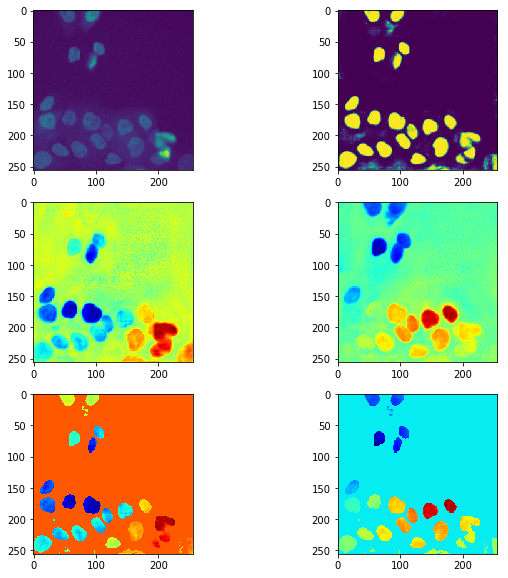

In [7]:
# 2D embedding
import matplotlib.pyplot as plt

channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

plt.rcParams['figure.figsize'] = [10, 10]

fg_thresh = test_images_fgbg[:, :, :, 1] > 0.4
fg_thresh = np.expand_dims(fg_thresh, axis=channel_axis)
test_images_post_fgbg=test_images[:, :, :, :] * fg_thresh

index = 0

plt.subplot(3, 2, 1)
plt.imshow(X_test[index, :, :, 0])

plt.subplot(3, 2, 2)
plt.imshow(test_images_fgbg[index, :, :, 1])

plt.subplot(3, 2, 3)
plt.imshow(test_images[index, :, :, 0], cmap='jet')

plt.subplot(3, 2, 4)
plt.imshow(test_images[index, :, :, 1], cmap='jet')

plt.subplot(3, 2, 5)
plt.imshow(test_images_post_fgbg[index, :, :, 0], cmap='jet')

plt.subplot(3, 2, 6)
plt.imshow(test_images_post_fgbg[index, :, :, 1], cmap='jet')

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_images= pca.fit(test_images_post_fgbg.reshape(-1, 16))

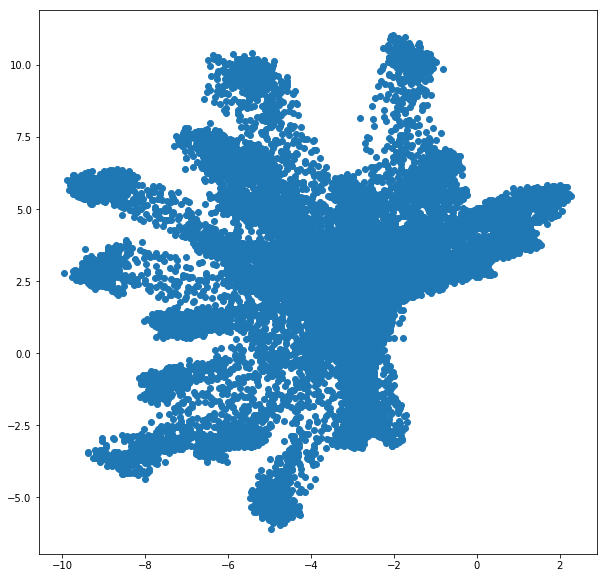

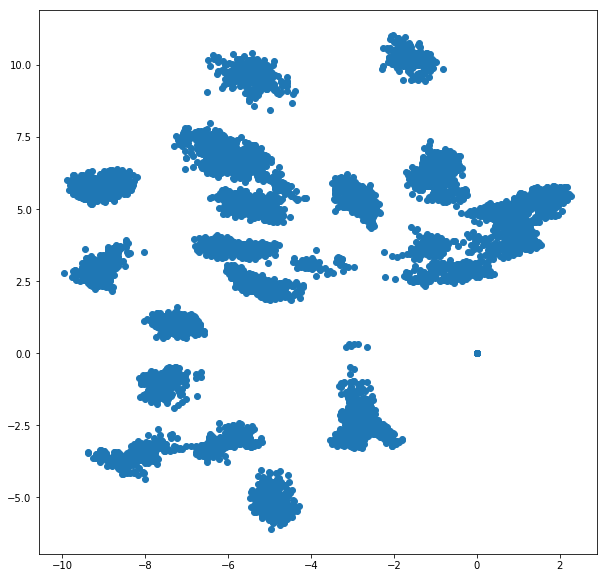

In [9]:
plt.figure()
test_plot = test_images[index, :, :, :].reshape(-1, 2)
plt.scatter(x=test_plot[:, 0], y=test_plot[:, 1])

plt.figure()
test_plot = test_images_post_fgbg[index, :, :, :].reshape(-1, 2)
plt.scatter(x=test_plot[:, 0], y=test_plot[:, 1])

In [10]:
# Mean Shift
from sklearn.cluster import MeanShift, estimate_bandwidth

test_plot = test_images_post_fgbg[index, :, :, :].reshape(-1, 2)
bandwidth = estimate_bandwidth(test_plot, n_samples=500)

In [11]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(test_plot)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 22


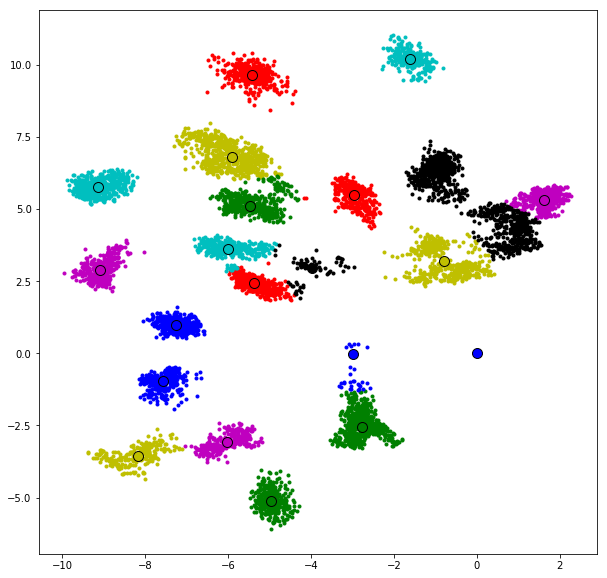

In [12]:
from itertools import cycle

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(test_plot[my_members, 0], test_plot[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=10)

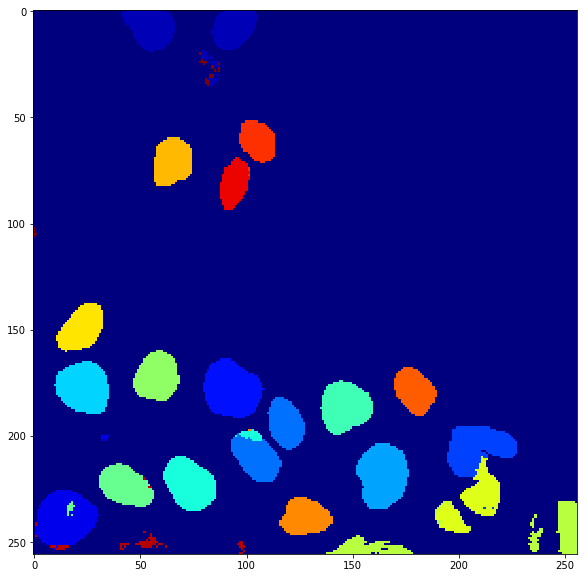

In [13]:
test_plot_mean_shift = labels.reshape(256, 256)
plt.imshow(test_plot_mean_shift, cmap='jet')

In [14]:
# DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics

test_plot = test_images_post_fgbg[index, :, :, :].reshape(-1, 2)

db = DBSCAN(eps=0.12, min_samples=5, algorithm='kd_tree').fit(test_plot)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 35


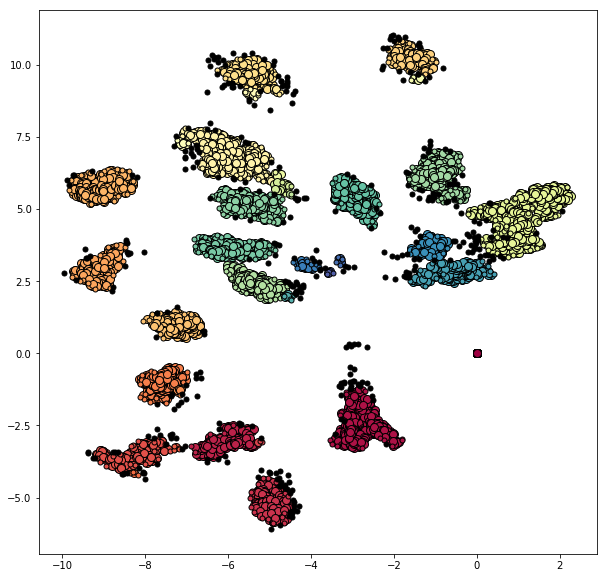

In [15]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = test_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=8)

    xy = test_plot[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

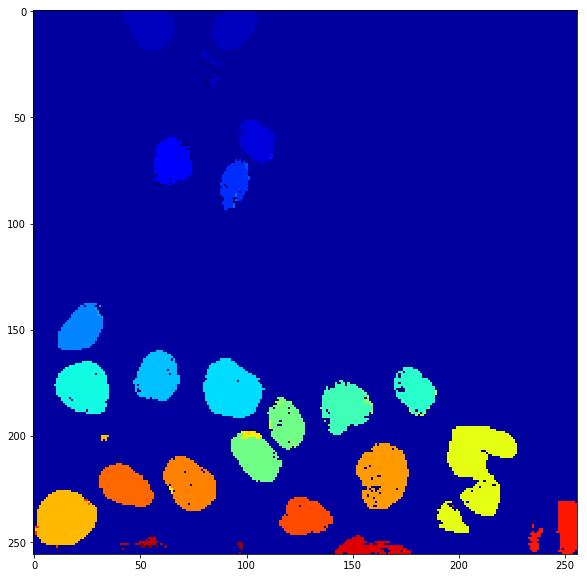

In [16]:
test_plot_dbscan = labels.reshape(256, 256)
plt.imshow(test_plot_dbscan, cmap='jet')

MeanShift - number of estimated clusters : 18
DBSCAN - Estimated number of clusters: 16


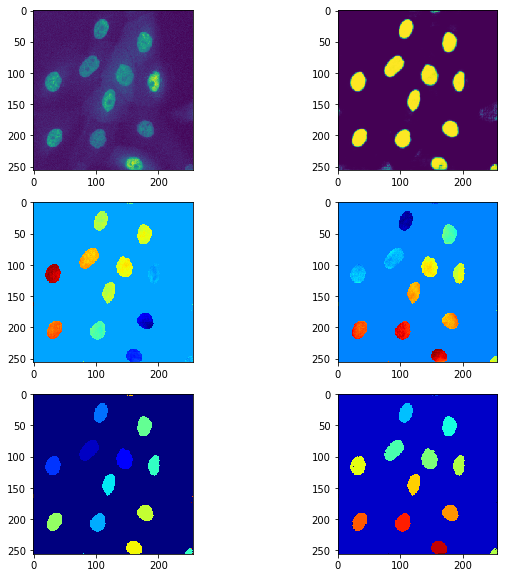

In [162]:
# 2D results review
index = 1

# Mean Shift
from sklearn.cluster import MeanShift, estimate_bandwidth

test_plot = test_images_post_fgbg[index, :, :, :].reshape(-1, 2)
bandwidth = estimate_bandwidth(test_plot, n_samples=2000)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(test_plot)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("MeanShift - number of estimated clusters : %d" % n_clusters_)

test_plot_mean_shift = labels.reshape(256, 256)


# DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics

test_plot = test_images_post_fgbg[index, :, :, :].reshape(-1, 2)

db = DBSCAN(eps=0.15, min_samples=5, algorithm='kd_tree').fit(test_plot)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('DBSCAN - Estimated number of clusters: %d' % n_clusters_)

test_plot_dbscan = labels.reshape(256, 256)


plt.subplot(3, 2, 1)
plt.imshow(X_test[index, :, :, 0])

plt.subplot(3, 2, 2)
plt.imshow(test_images_fgbg[index, :, :, 1])

plt.subplot(3, 2, 3)
plt.imshow(test_images_post_fgbg[index, :, :, 0], cmap='jet')

plt.subplot(3, 2, 4)
plt.imshow(test_images_post_fgbg[index, :, :, 1], cmap='jet')

plt.subplot(3, 2, 5)
plt.imshow(test_plot_mean_shift, cmap='jet')

plt.subplot(3, 2, 6)
plt.imshow(test_plot_dbscan, cmap='jet')

MeanShift - number of estimated clusters : 23


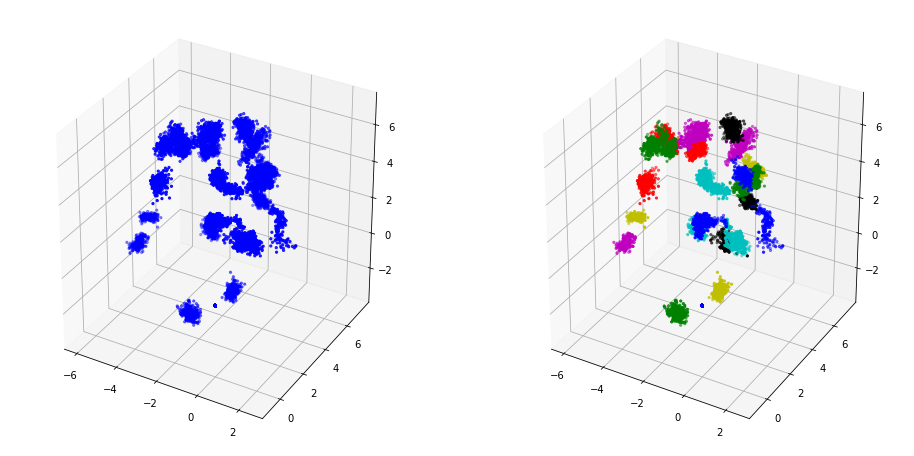

In [96]:
# 3D embedding
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

plt.rcParams['figure.figsize'] = [16, 8]

fg_thresh = test_images_fgbg[:, :, :, 1] > 0.6
fg_thresh = np.expand_dims(fg_thresh, axis=channel_axis)
test_images_post_fgbg=test_images[:, :, :, :] * fg_thresh

index = 0

# Mean Shift
from sklearn.cluster import MeanShift, estimate_bandwidth

test_plot = test_images_post_fgbg[index, :, :, :].reshape(-1, 3)
bandwidth = estimate_bandwidth(test_plot, n_samples=2000)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(test_plot)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
test_plot_mean_shift = labels.reshape(256, 256)

print("MeanShift - number of estimated clusters : %d" % n_clusters_)

# Original
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.scatter(test_plot[:, 0], test_plot[:, 1], test_plot[:, 2], c='b', marker='o', s=5)

# Scatter plot after MeanShift 
from itertools import cycle

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
ax = fig.add_subplot(122, projection='3d')

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    ax.scatter(test_plot[my_members, 0], test_plot[my_members, 1], test_plot[my_members, 2], c=col, s=5)


DBSCAN - Estimated number of clusters: 29


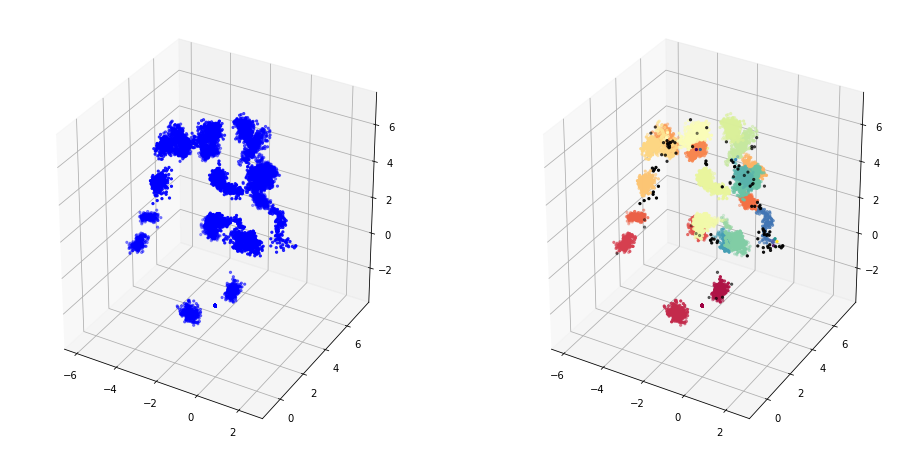

In [97]:
# DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics

test_plot = test_images_post_fgbg[index, :, :, :].reshape(-1, 3)

db = DBSCAN(eps=0.2, min_samples=5, algorithm='kd_tree').fit(test_plot)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
test_plot_dbscan = labels.reshape(256, 256)

print('DBSCAN - Estimated number of clusters: %d' % n_clusters_)


# Original
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.scatter(test_plot[:, 0], test_plot[:, 1], test_plot[:, 2], c='b', marker='o', s=5)

# Scatter plot after DBScan
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
ax = fig.add_subplot(122, projection='3d')

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = test_plot[class_member_mask & core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2],'o', c=col, s=5)

    xy = test_plot[class_member_mask & ~core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2],'o', c=col, s=5)

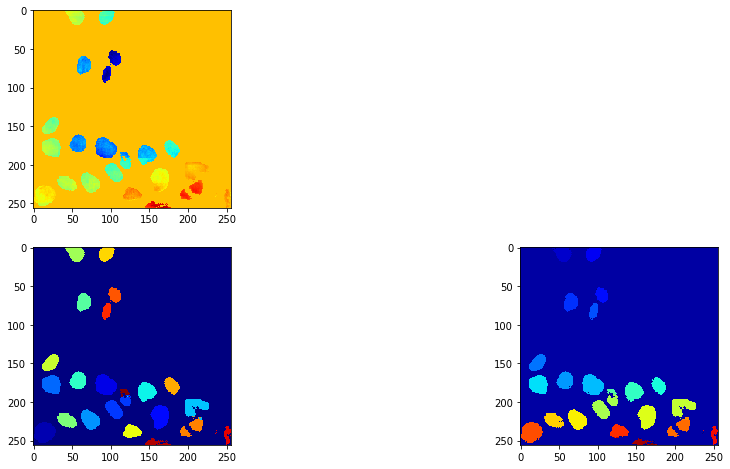

In [98]:
plt.subplot(2, 2, 1)
plt.imshow(test_images_post_fgbg[index, :, :, 0], cmap='jet')

plt.subplot(2, 2, 3)
plt.imshow(test_plot_mean_shift, cmap='jet')

plt.subplot(2, 2, 4)
plt.imshow(test_plot_dbscan, cmap='jet')

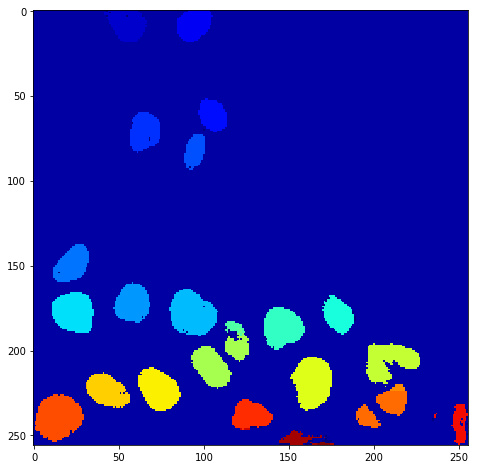

In [99]:
plt.imshow(test_plot_dbscan, cmap='jet')